## Model Training 
#### 1.1 Import Data and Required Packages 
Importing Pandas,Numpy,Matplotlib,Seaborn,Warning and Modeling Techniques Library  

In [20]:
# Basic Import 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Modeling Techniques Library
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import category_encoders as ce  
import warnings

##### Import the csv as Pandas DataFrame

In [21]:
df=pd.read_csv('Cleaned_Reals_Estate_Data.csv')

##### Show Top 5 Records

In [22]:
df.head()

,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Profit
0,2020,2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,Single Family,174500.0
1,2020,2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,177000.0
2,2020,2021,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,49500.0
3,2020,2021,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,270710.0
4,2020,2021,Avon,70 FAR HILLS DRIVE,862330.0,1447500.0,0.5957,Residential,Single Family,585170.0


##### Preparing X and Y variables

In [23]:
X=df.drop(columns=['Sale Amount', 'Profit'],axis=1)

In [24]:
X.head()

,List Year,Date Recorded,Town,Address,Assessed Value,Sales Ratio,Property Type,Residential Type
0,2020,2021,Ansonia,230 WAKELEE AVE,150500.0,0.4630,Commercial,Single Family
1,2020,2020,Ashford,390 TURNPIKE RD,253000.0,0.5883,Residential,Single Family
2,2020,2021,Avon,5 CHESTNUT DRIVE,130400.0,0.7248,Residential,Condo
3,2020,2021,Avon,111 NORTHINGTON DRIVE,619290.0,0.6958,Residential,Single Family
4,2020,2021,Avon,70 FAR HILLS DRIVE,862330.0,0.5957,Residential,Single Family


In [25]:
y=df['Sale Amount']

In [26]:
y

0          325000.0
1          430000.0
2          179900.0
3          890000.0
4         1447500.0
            ...    
996897      53100.0
996898      76000.0
996899     210000.0
996900     280000.0
996901    7450000.0
Name: Sale Amount, Length: 996902, dtype: float64

##### Create and Evaluate function to give all metrics after model training 

In [27]:
def evaluate_model(true, predicted):
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true, predicted)
    rmse=np.sqrt(mse)
    r2_square= r2_score(true, predicted)
    return mae,rmse,r2_square

##### Evaluating each model 
- Encoding the categorical variable 
- Tranforming the columns using ColumnTransformer
- Separating the dataset into train and test

In [28]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Subsample the data
subsample_fraction = 0.1  # Adjust this fraction to subsample the data
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=subsample_fraction, random_state=42)

# Separate numerical and categorical features
num_features = X_sample.select_dtypes(exclude="object").columns
cat_features = X_sample.select_dtypes(include="object").columns

# Identify High Cardinality features
high_card_features = [feature for feature in cat_features if X_sample[feature].nunique() > 100]
low_card_features = [feature for feature in cat_features if X_sample[feature].nunique() <= 100]

# Initialize transformers
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(handle_unknown='ignore')
target_encoder = ce.TargetEncoder(cols=high_card_features)

# Defining the preprocessor without TargetEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ("StandardScaler", numeric_transformer, num_features),
        ("OneHotEncoder", oh_transformer, low_card_features)
    ]
)

# Apply TargetEncoder separately
X_high_card_encoded = target_encoder.fit_transform(X_sample[high_card_features], y_sample)

# Apply the remaining transformations
X_other_transformed = preprocessor.fit_transform(X_sample.drop(columns=high_card_features))

# Combine the results
X_preprocessed = np.hstack((X_high_card_encoded, X_other_transformed))


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(max_iter=1000),
    "Lasso": Lasso(max_iter=1000),  # Increase iterations for convergence
    "K-Neighbors Regression": KNeighborsRegressor(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(n_jobs=-1),
    "XGBRegressor": XGBRegressor(n_jobs=-1),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Split the preprocessed data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_sample, test_size=0.2, random_state=42)

# Train and evaluate models
model_list = []
r2_list = []

for model_name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate model
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Print results
    print(f"Model: {model_name}")
    model_list.append(model_name)
    
    print("Model performance for training set")
    print(f"- Root Mean Squared Error: {model_train_rmse:.4f}")
    print(f"- Mean Absolute Error: {model_train_mae:.4f}")
    print(f"- R2 score: {model_train_r2:.4f}")
    
    print('----------------------------------')
    
    print('Model performance for test set')
    print(f"- Root Mean Squared Error: {model_test_rmse:.4f}")
    print(f"- Mean Absolute Error: {model_test_mae:.4f}")
    print(f"- R2 Score: {model_test_r2:.4f}")
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Model: Linear Regression
Model performance for training set
- Root Mean Squared Error: 213230.2098
- Mean Absolute Error: 14927.2360
- R2 score: 0.9926
----------------------------------
Model performance for test set
- Root Mean Squared Error: 276654.6748
- Mean Absolute Error: 18388.4312
- R2 Score: 0.9999


Model: Ridge Regression
Model performance for training set
- Root Mean Squared Error: 213230.2107
- Mean Absolute Error: 14927.1419
- R2 score: 0.9926
----------------------------------
Model performance for test set
- Root Mean Squared Error: 276648.0229
- Mean Absolute Error: 18387.9209
- R2 Score: 0.9999




c:\Users\SLEEMTEECH\Desktop\Real Estate Price prediction\REPP\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.86323e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\SLEEMTEECH\Desktop\Real Estate Price prediction\REPP\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+15, tolerance: 4.896e+13
  model = cd_fast.enet_coordinate_descent(


Model: Lasso
Model performance for training set
- Root Mean Squared Error: 213230.2558
- Mean Absolute Error: 14925.5930
- R2 score: 0.9926
----------------------------------
Model performance for test set
- Root Mean Squared Error: 276625.5620
- Mean Absolute Error: 18384.1651
- R2 Score: 0.9999


Model: K-Neighbors Regression
Model performance for training set
- Root Mean Squared Error: 822409.4345
- Mean Absolute Error: 19697.7370
- R2 score: 0.8898
----------------------------------
Model performance for test set
- Root Mean Squared Error: 33700748.7938
- Mean Absolute Error: 261388.1773
- R2 Score: 0.0958


Model: Decision Tree
Model performance for training set
- Root Mean Squared Error: 468.2715
- Mean Absolute Error: 3.8620
- R2 score: 1.0000
----------------------------------
Model performance for test set
- Root Mean Squared Error: 32611145.8898
- Mean Absolute Error: 246974.8514
- R2 Score: 0.1533


Model: Random Forest Regressor
Model performance for training set
- Root Mea

##### Converting the result to DataFrame

In [29]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Lasso,0.999939
1,Ridge Regression,0.999939
0,Linear Regression,0.999939
4,Decision Tree,0.153350
8,AdaBoost Regressor,0.153199
6,XGBRegressor,0.151857
5,Random Forest Regressor,0.143854
3,K-Neighbors Regression,0.095828
7,CatBoosting Regressor,0.026696


##### Linear Regression

In [30]:
lin_model =LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 99.99


#### Plot y_pred and y_test

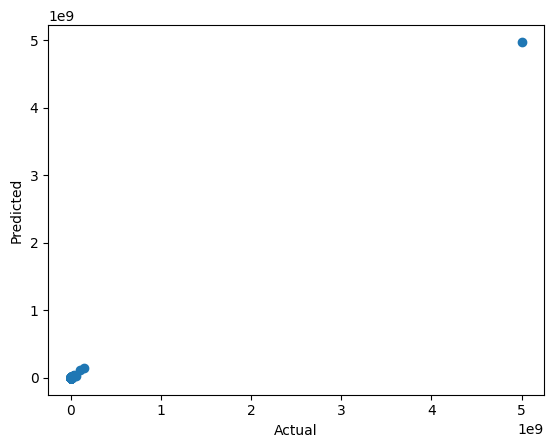

In [31]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

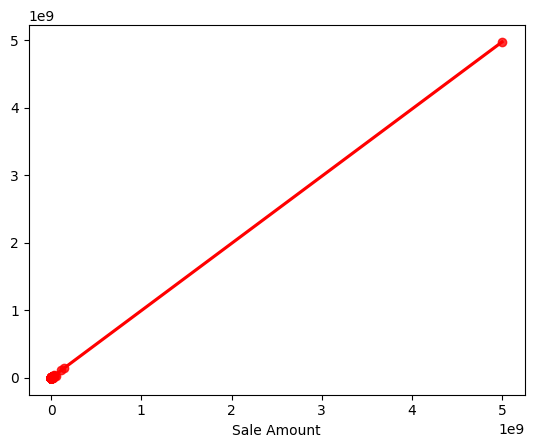

In [32]:
sns.regplot(x=y_test,y=y_pred,ci=None,color='red');

##### Difference between Actual and Predicted Values

In [33]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
941254,140000.0,143273.944556,-3273.944556
384315,164000.0,162944.428780,1055.571220
155562,210000.0,207735.845284,2264.154716
834385,295000.0,298681.163510,-3681.163510
415923,442500.0,441766.204677,733.795323
...,...,...,...
356029,249000.0,247681.741432,1318.258568
752919,460000.0,465073.164828,-5073.164828
520709,174900.0,175490.945985,-590.945985
262037,689000.0,686576.359976,2423.640024
